#Consigna



Entrenar un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación de neumotórax. 

Los datos se pueden descargar directamente a una máquina virtual (VM) de colab desde Kaggle. El instructivo para hacerlo (tener en cuanta que hay que descargar otra vez cuando termina la sesión). 

Se usarán los datos de:

https://www.kaggle.com/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks

Reportar la métrica de Dice para un conjunto de test a definir, el mismo dataset provee de un conjunto de imágenes de testeo. Puede usarse ese conjunto o separar un conjunto propio a partir de todos los datos.

Para este TP no hay una métrica objetivo a alcanzar, se intenta en lo posible que la métrica de Dice sea lo más cercana a 1. Reportar el modelo con mejor desempeño (hiperparámetros utilizados, si se usó aumentación de datos y qué tipo de aumentación, etc...) y mostrar algunos ejemplos de segmentación. No es necesario hacer un submit a Kaggle. 

Recomendaciones:

* Trabajar a partir de la notebook de segmentación vista en clase.
* Se puede entrenar y evaluar solamente con las imágenes que contengan patologías.








#Drive e importacion de librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 36.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Dataset

Se genera un directorio de nombre siim-acr-pneumothorax. El contenido de este directorio son dos dataframes en formato .csv para las imágenes de train y test y dos directorios que contienen imágenes y sus máscaras de segmentación correspondientes. Las imágenes y las máscaras tienen un patrón de nombre formado por:

ID_SET_PAT_.png

Donde ID es un número de identificación, SET indica si la imagen pertenece al conjunto de "train" o "test" y PAT puede tomar los valores 0 o 1. 0 en el caso que esa imagen no contenga neumotórax y 1 en caso de que sí contenga patología. Este dataset se compone de 10675 imágenes de entrenamiento y 1372 de testeo.

Se utilizaron dos casos de dataset, el primero con 64 imagenes (elegidas aleatoriamente) de train y test y 64 masks train y test, todas con patalogia. Y para el segundo caso se hizo lo mismo pero con 2000 imagenes.

In [3]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
#!cp -R "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset_2/siim-acr-pneumothorax/"* /content/data

In [ ]:
#path_data ="/content/data/"

In [4]:
path_nuevoDataset = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

Dataset de 2000 imagenes

In [5]:
import random
def reducir_dataset_train_2(path,cant_elementos = 2000):
  filenames = [file.name for file in Path(path).glob('png_image/img/*train_1_.png')]
  new_filenames = random.sample(filenames, cant_elementos)
  for file in new_filenames:
    img = Image.open(path+"png_image/img/"+file)
    img.save("/content/data_reducida_images_2/"+file)
    mask = Image.open(path+"png_masks/img/"+file)
    mask.save("/content/data_reducida_masks_2/"+file)
  print("Len random element is :", len(new_filenames))

In [6]:
reducir_dataset_train_2(path_nuevoDataset)

Len random element is : 2000


Se abren algunas imagenes del dataset para ver como son.

In [7]:
img1 = Image.open(path_nuevoDataset+"png_image/img/10_train_1_.png")
mask1 = Image.open(path_nuevoDataset+"png_masks/img/10_train_1_.png")

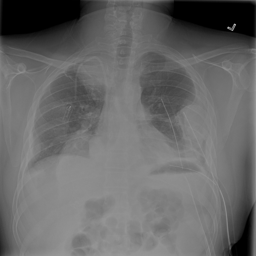

In [8]:
img1.resize((256,256))

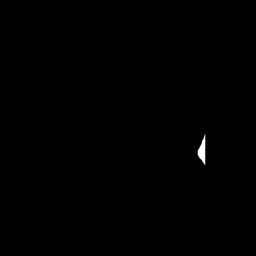

In [9]:
mask1.resize((256,256))

## Data-Augmentation

Dado que en general las redes Neuronales tienen grandes cantidades de parametros, necesitamos tener una cantidad proporcional de data a la cantidad de parametros para tener una buena performance. Por eso, se usa lo que se conoce como Data Augmentation que consiste en hacer alteraciones menores sobre el dataset para obtener más cantidad imagenes.

Estás alteraciones pueden ser: Flips, translations, rotations, entre otras, ya que nuestra red neuronal igualmente las va a distinguir como imagenes diferentes.

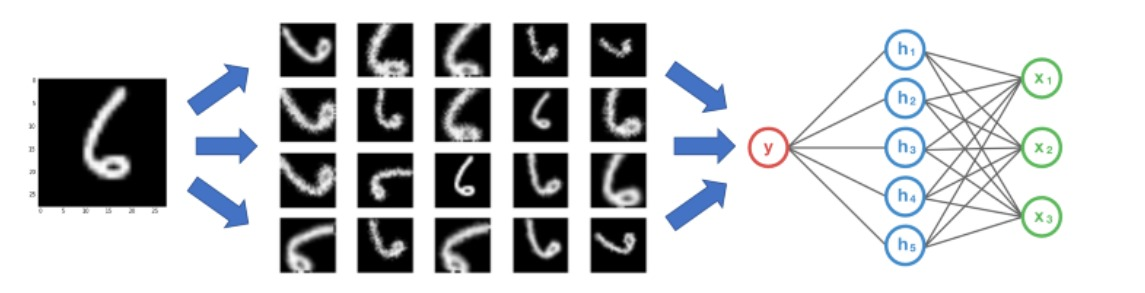

In [10]:
#VECTOR DE TRANSFORMACION DE DATA-AUGMENTATION

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    
])
#transform = False

#Generar data

Explicar que es un generetor, esto es para no tener todas las imagenes almacenadas,esto pasa cuando tenes muchos datos.

Hoy en día en el campo del Machine Learning cada vez se vuelve un problema más frecuente el hecho de tener que usar grandes datasets. El inconveniente es que al estar trabajando con imagenes el procesamiento por parte del modelo va a ocupar mucha memoria RAM, al usar un generador se evita tener el dataset entero ocupando espacio de forma necesaria.
Lo que se hace es generar un conjunto de datos en múltiples núcleos en tiempo real y alimentarlo de inmediato al modelo de red.

In [11]:
import tensorflow as tf
 
class DataGenerator_2(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(64,64), train=True,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("data_reducida_images_2/*.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_image/img/*test_1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

Esta clase Generador es la que se pasara al modelo a fitear. A medida que se arman los batchs de entrenamiento, a cada imagen se le aplica:

- Una reducción de resolución.Por un tema de rápidez de procesamiento y poder agrandar el batch_size con el que se trabaja, se buscó hacer una reducción de resolución con la mínima cantidad de perdida de información posible, es por esto que se utilizo la dimension (128,128)


- Se le aplica la transformacion del Data Augmentation, excepto para el validation

- Cuando se usaron 64 imagenes se eligio un bachsize de 32, mientras que cuando se usaron 2000 imagenes se uso un bachsize de 64.


### Generacion data TRAIN

* Dataset 2000

In [12]:
datagen_2_False = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [13]:
len(datagen_2_False)

31

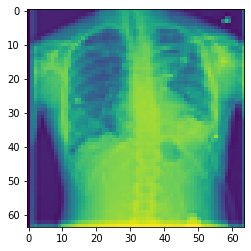

In [14]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_False[0][0][0].reshape(64,64))

In [15]:
datagen_2_True = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = transform,
    shuffle= True,
    batch_size = 64,
    train = True  
)

In [16]:
len(datagen_2_True)

31

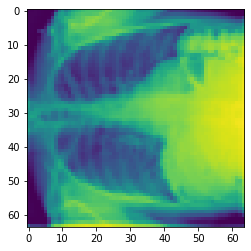

In [17]:
from matplotlib import pyplot as plt
plt.imshow(datagen_2_True[10][0][0].reshape(64,64))

### Generacion data VALIDATION

* Dataset 2000

In [18]:
datagen_val_2 = DataGenerator_2(
    "/content/",
    "data_reducida_images_2/",
    "data_reducida_masks_2/",
    transform = False,
    shuffle= True,
    batch_size = 64,
    train = True, 
)

#Modelo

## Descripcion del UNet

Una red neuronal convolucional  enfoca su tarea en la clasificacion de imagenes donde la entrada es una imagen y la salida es una etiqueta. En casos biomedicos se requiere no solo distinguir si hay una enfermedad si no tambien localizar el area de anormalidad y Unet puede resolver este problema ya que es capaz de localizar y distinguir bordes mediante la clasificacion de cada pixel, de modo que la entrada y la salida comparten el mismo tamaño.
La forma basica de la red se puede ver en la imganena continuacion:

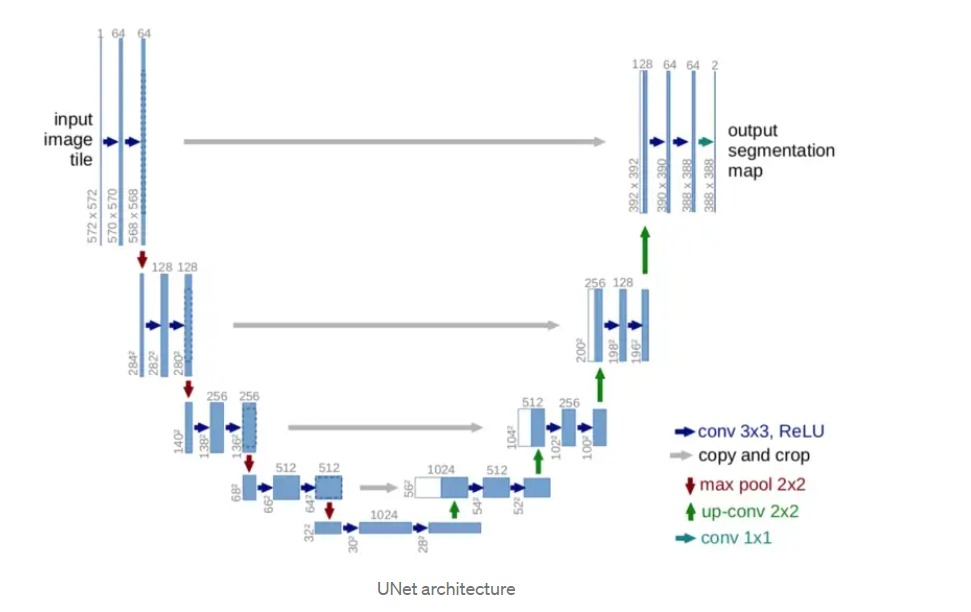

## Modelos planteados

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [20]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

In [21]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [22]:
# instanciación del modelo
model = UNet((64,64,1),start_ch=32,depth=5,batchnorm=False, residual = True,dropout=False)

In [23]:
# compilación
model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

## Caso 7:
* 2000 imagenes, con Transform= False y epocs= 50

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
epocs = 50
verbose = 1
monitor='loss'
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
#model.fit(datagen, epochs = epocs, validation_data=datagen_val, callbacks=[checkpointer])

In [25]:
history = model.fit(datagen_2_False, epochs = epocs, validation_data=datagen_val_2, callbacks=[checkpointer])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.6241 - binary_crossentropy: 0.2673 - dice_coef: 0.0192
Epoch 1: val_loss improved from inf to 0.51499, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 128s 4s/step - loss: 0.6241 - binary_crossentropy: 0.2673 - dice_coef: 0.0192 - val_loss: 0.5150 - val_binary_crossentropy: 0.0693 - val_dice_coef: 0.0393
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.4908 - binary_crossentropy: 0.0780 - dice_coef: 0.0965
Epoch 2: val_loss improved from 0.51499 to 0.47823, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.4908 - binary_crossentropy: 0.0780 - dice_coef: 0.0965 - val_loss: 0.4782 - val_binary_crossentropy: 0.0907 - val_dice_coef: 0.1342
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.4674 - binary_crossentropy: 0.0849 - dice_coef: 0.1502
Epoch 3: val_loss improved from 0.47823 to 0.45679, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.4674 - binary_crossentropy: 0.0849 - dice_coef: 0.1502 - val_loss: 0.4568 - val_binary_crossentropy: 0.0792 - val_dice_coef: 0.1656
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.4567 - binary_crossentropy: 0.0851 - dice_coef: 0.1718
Epoch 4: val_loss improved from 0.45679 to 0.44222, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 4s/step - loss: 0.4567 - binary_crossentropy: 0.0851 - dice_coef: 0.1718 - val_loss: 0.4422 - val_binary_crossentropy: 0.0735 - val_dice_coef: 0.1891
Epoch 5/50
31/31 [==============================] - ETA: 0s - loss: 0.4340 - binary_crossentropy: 0.0823 - dice_coef: 0.2144
Epoch 5: val_loss improved from 0.44222 to 0.42582, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.4340 - binary_crossentropy: 0.0823 - dice_coef: 0.2144 - val_loss: 0.4258 - val_binary_crossentropy: 0.0855 - val_dice_coef: 0.2339
Epoch 6/50
31/31 [==============================] - ETA: 0s - loss: 0.4200 - binary_crossentropy: 0.0818 - dice_coef: 0.2419
Epoch 6: val_loss improved from 0.42582 to 0.41013, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 4s/step - loss: 0.4200 - binary_crossentropy: 0.0818 - dice_coef: 0.2419 - val_loss: 0.4101 - val_binary_crossentropy: 0.0861 - val_dice_coef: 0.2658
Epoch 7/50
31/31 [==============================] - ETA: 0s - loss: 0.4086 - binary_crossentropy: 0.0810 - dice_coef: 0.2638
Epoch 7: val_loss improved from 0.41013 to 0.39882, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.4086 - binary_crossentropy: 0.0810 - dice_coef: 0.2638 - val_loss: 0.3988 - val_binary_crossentropy: 0.0792 - val_dice_coef: 0.2816
Epoch 8/50
31/31 [==============================] - ETA: 0s - loss: 0.3906 - binary_crossentropy: 0.0761 - dice_coef: 0.2949
Epoch 8: val_loss improved from 0.39882 to 0.37943, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.3906 - binary_crossentropy: 0.0761 - dice_coef: 0.2949 - val_loss: 0.3794 - val_binary_crossentropy: 0.0763 - val_dice_coef: 0.3174
Epoch 9/50
31/31 [==============================] - ETA: 0s - loss: 0.3810 - binary_crossentropy: 0.0755 - dice_coef: 0.3134
Epoch 9: val_loss improved from 0.37943 to 0.36576, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 3s/step - loss: 0.3810 - binary_crossentropy: 0.0755 - dice_coef: 0.3134 - val_loss: 0.3658 - val_binary_crossentropy: 0.0672 - val_dice_coef: 0.3357
Epoch 10/50
31/31 [==============================] - ETA: 0s - loss: 0.3713 - binary_crossentropy: 0.0738 - dice_coef: 0.3311
Epoch 10: val_loss did not improve from 0.36576
31/31 [==============================] - 101s 3s/step - loss: 0.3713 - binary_crossentropy: 0.0738 - dice_coef: 0.3311 - val_loss: 0.3683 - val_binary_crossentropy: 0.0846 - val_dice_coef: 0.3480
Epoch 11/50
31/31 [==============================] - ETA: 0s - loss: 0.3621 - binary_crossentropy: 0.0738 - dice_coef: 0.3497
Epoch 11: val_loss improved from 0.36576 to 0.34684, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 106s 3s/step - loss: 0.3621 - binary_crossentropy: 0.0738 - dice_coef: 0.3497 - val_loss: 0.3468 - val_binary_crossentropy: 0.0690 - val_dice_coef: 0.3753
Epoch 12/50
31/31 [==============================] - ETA: 0s - loss: 0.3502 - binary_crossentropy: 0.0709 - dice_coef: 0.3706
Epoch 12: val_loss improved from 0.34684 to 0.34250, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.3502 - binary_crossentropy: 0.0709 - dice_coef: 0.3706 - val_loss: 0.3425 - val_binary_crossentropy: 0.0710 - val_dice_coef: 0.3860
Epoch 13/50
31/31 [==============================] - ETA: 0s - loss: 0.3396 - binary_crossentropy: 0.0677 - dice_coef: 0.3885
Epoch 13: val_loss improved from 0.34250 to 0.32772, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 110s 4s/step - loss: 0.3396 - binary_crossentropy: 0.0677 - dice_coef: 0.3885 - val_loss: 0.3277 - val_binary_crossentropy: 0.0707 - val_dice_coef: 0.4152
Epoch 14/50
31/31 [==============================] - ETA: 0s - loss: 0.3292 - binary_crossentropy: 0.0678 - dice_coef: 0.4093
Epoch 14: val_loss improved from 0.32772 to 0.32421, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 4s/step - loss: 0.3292 - binary_crossentropy: 0.0678 - dice_coef: 0.4093 - val_loss: 0.3242 - val_binary_crossentropy: 0.0779 - val_dice_coef: 0.4295
Epoch 15/50
31/31 [==============================] - ETA: 0s - loss: 0.3296 - binary_crossentropy: 0.0705 - dice_coef: 0.4113
Epoch 15: val_loss did not improve from 0.32421
31/31 [==============================] - 102s 3s/step - loss: 0.3296 - binary_crossentropy: 0.0705 - dice_coef: 0.4113 - val_loss: 0.3552 - val_binary_crossentropy: 0.0801 - val_dice_coef: 0.3697
Epoch 16/50
31/31 [==============================] - ETA: 0s - loss: 0.3311 - binary_crossentropy: 0.0673 - dice_coef: 0.4050
Epoch 16: val_loss improved from 0.32421 to 0.31555, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 106s 3s/step - loss: 0.3311 - binary_crossentropy: 0.0673 - dice_coef: 0.4050 - val_loss: 0.3155 - val_binary_crossentropy: 0.0630 - val_dice_coef: 0.4319
Epoch 17/50
31/31 [==============================] - ETA: 0s - loss: 0.3143 - binary_crossentropy: 0.0659 - dice_coef: 0.4374
Epoch 17: val_loss improved from 0.31555 to 0.30865, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.3143 - binary_crossentropy: 0.0659 - dice_coef: 0.4374 - val_loss: 0.3087 - val_binary_crossentropy: 0.0652 - val_dice_coef: 0.4479
Epoch 18/50
31/31 [==============================] - ETA: 0s - loss: 0.3038 - binary_crossentropy: 0.0628 - dice_coef: 0.4552
Epoch 18: val_loss improved from 0.30865 to 0.29617, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 3s/step - loss: 0.3038 - binary_crossentropy: 0.0628 - dice_coef: 0.4552 - val_loss: 0.2962 - val_binary_crossentropy: 0.0578 - val_dice_coef: 0.4654
Epoch 19/50
31/31 [==============================] - ETA: 0s - loss: 0.2994 - binary_crossentropy: 0.0629 - dice_coef: 0.4640
Epoch 19: val_loss improved from 0.29617 to 0.28084, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.2994 - binary_crossentropy: 0.0629 - dice_coef: 0.4640 - val_loss: 0.2808 - val_binary_crossentropy: 0.0585 - val_dice_coef: 0.4968
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 0.2914 - binary_crossentropy: 0.0610 - dice_coef: 0.4783
Epoch 20: val_loss improved from 0.28084 to 0.27386, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.2914 - binary_crossentropy: 0.0610 - dice_coef: 0.4783 - val_loss: 0.2739 - val_binary_crossentropy: 0.0578 - val_dice_coef: 0.5101
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 0.2837 - binary_crossentropy: 0.0592 - dice_coef: 0.4917
Epoch 21: val_loss did not improve from 0.27386
31/31 [==============================] - 100s 3s/step - loss: 0.2837 - binary_crossentropy: 0.0592 - dice_coef: 0.4917 - val_loss: 0.3006 - val_binary_crossentropy: 0.0673 - val_dice_coef: 0.4661
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 0.2866 - binary_crossentropy: 0.0619 - dice_coef: 0.4888
Epoch 22: val_loss improved from 0.27386 to 0.26236, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 4s/step - loss: 0.2866 - binary_crossentropy: 0.0619 - dice_coef: 0.4888 - val_loss: 0.2624 - val_binary_crossentropy: 0.0573 - val_dice_coef: 0.5326
Epoch 23/50
31/31 [==============================] - ETA: 0s - loss: 0.2669 - binary_crossentropy: 0.0560 - dice_coef: 0.5222
Epoch 23: val_loss improved from 0.26236 to 0.25623, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 106s 3s/step - loss: 0.2669 - binary_crossentropy: 0.0560 - dice_coef: 0.5222 - val_loss: 0.2562 - val_binary_crossentropy: 0.0522 - val_dice_coef: 0.5397
Epoch 24/50
31/31 [==============================] - ETA: 0s - loss: 0.2580 - binary_crossentropy: 0.0555 - dice_coef: 0.5395
Epoch 24: val_loss improved from 0.25623 to 0.25133, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.2580 - binary_crossentropy: 0.0555 - dice_coef: 0.5395 - val_loss: 0.2513 - val_binary_crossentropy: 0.0548 - val_dice_coef: 0.5522
Epoch 25/50
31/31 [==============================] - ETA: 0s - loss: 0.2610 - binary_crossentropy: 0.0553 - dice_coef: 0.5332
Epoch 25: val_loss improved from 0.25133 to 0.25105, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.2610 - binary_crossentropy: 0.0553 - dice_coef: 0.5332 - val_loss: 0.2511 - val_binary_crossentropy: 0.0532 - val_dice_coef: 0.5511
Epoch 26/50
31/31 [==============================] - ETA: 0s - loss: 0.2573 - binary_crossentropy: 0.0562 - dice_coef: 0.5417
Epoch 26: val_loss did not improve from 0.25105
31/31 [==============================] - 99s 3s/step - loss: 0.2573 - binary_crossentropy: 0.0562 - dice_coef: 0.5417 - val_loss: 0.2555 - val_binary_crossentropy: 0.0566 - val_dice_coef: 0.5456
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 0.2499 - binary_crossentropy: 0.0533 - dice_coef: 0.5536
Epoch 27: val_loss did not improve from 0.25105
31/31 [==============================] - 101s 3s/step - loss: 0.2499 - binary_crossentropy: 0.0533 - dice_coef: 0.5536 - val_loss: 0.2538 - val_binary_crossentropy: 0.0565 - val_dice_coef: 0.5490
Epoch 28/50
31/31 [==============================] - ETA: 0s - lo

31/31 [==============================] - 107s 3s/step - loss: 0.2506 - binary_crossentropy: 0.0529 - dice_coef: 0.5518 - val_loss: 0.2403 - val_binary_crossentropy: 0.0496 - val_dice_coef: 0.5691
Epoch 29/50
31/31 [==============================] - ETA: 0s - loss: 0.2383 - binary_crossentropy: 0.0515 - dice_coef: 0.5749
Epoch 29: val_loss improved from 0.24027 to 0.22873, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.2383 - binary_crossentropy: 0.0515 - dice_coef: 0.5749 - val_loss: 0.2287 - val_binary_crossentropy: 0.0474 - val_dice_coef: 0.5899
Epoch 30/50
31/31 [==============================] - ETA: 0s - loss: 0.2276 - binary_crossentropy: 0.0500 - dice_coef: 0.5949
Epoch 30: val_loss improved from 0.22873 to 0.21550, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.2276 - binary_crossentropy: 0.0500 - dice_coef: 0.5949 - val_loss: 0.2155 - val_binary_crossentropy: 0.0460 - val_dice_coef: 0.6150
Epoch 31/50
31/31 [==============================] - ETA: 0s - loss: 0.2191 - binary_crossentropy: 0.0473 - dice_coef: 0.6092
Epoch 31: val_loss did not improve from 0.21550
31/31 [==============================] - 103s 3s/step - loss: 0.2191 - binary_crossentropy: 0.0473 - dice_coef: 0.6092 - val_loss: 0.2236 - val_binary_crossentropy: 0.0473 - val_dice_coef: 0.6000
Epoch 32/50
31/31 [==============================] - ETA: 0s - loss: 0.2275 - binary_crossentropy: 0.0495 - dice_coef: 0.5945
Epoch 32: val_loss did not improve from 0.21550
31/31 [==============================] - 100s 3s/step - loss: 0.2275 - binary_crossentropy: 0.0495 - dice_coef: 0.5945 - val_loss: 0.2161 - val_binary_crossentropy: 0.0458 - val_dice_coef: 0.6136
Epoch 33/50
31/31 [==============================] - ETA: 0s - l

31/31 [==============================] - 106s 3s/step - loss: 0.2139 - binary_crossentropy: 0.0473 - dice_coef: 0.6194 - val_loss: 0.2093 - val_binary_crossentropy: 0.0433 - val_dice_coef: 0.6248
Epoch 36/50
31/31 [==============================] - ETA: 0s - loss: 0.2043 - binary_crossentropy: 0.0455 - dice_coef: 0.6368
Epoch 36: val_loss improved from 0.20925 to 0.19325, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.2043 - binary_crossentropy: 0.0455 - dice_coef: 0.6368 - val_loss: 0.1933 - val_binary_crossentropy: 0.0430 - val_dice_coef: 0.6565
Epoch 37/50
31/31 [==============================] - ETA: 0s - loss: 0.1978 - binary_crossentropy: 0.0438 - dice_coef: 0.6483
Epoch 37: val_loss improved from 0.19325 to 0.18990, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 3s/step - loss: 0.1978 - binary_crossentropy: 0.0438 - dice_coef: 0.6483 - val_loss: 0.1899 - val_binary_crossentropy: 0.0388 - val_dice_coef: 0.6590
Epoch 38/50
31/31 [==============================] - ETA: 0s - loss: 0.1912 - binary_crossentropy: 0.0431 - dice_coef: 0.6607
Epoch 38: val_loss improved from 0.18990 to 0.18362, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 4s/step - loss: 0.1912 - binary_crossentropy: 0.0431 - dice_coef: 0.6607 - val_loss: 0.1836 - val_binary_crossentropy: 0.0414 - val_dice_coef: 0.6742
Epoch 39/50
31/31 [==============================] - ETA: 0s - loss: 0.1899 - binary_crossentropy: 0.0420 - dice_coef: 0.6623
Epoch 39: val_loss did not improve from 0.18362
31/31 [==============================] - 100s 3s/step - loss: 0.1899 - binary_crossentropy: 0.0420 - dice_coef: 0.6623 - val_loss: 0.1905 - val_binary_crossentropy: 0.0433 - val_dice_coef: 0.6623
Epoch 40/50
31/31 [==============================] - ETA: 0s - loss: 0.1836 - binary_crossentropy: 0.0414 - dice_coef: 0.6741
Epoch 40: val_loss improved from 0.18362 to 0.17541, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 107s 3s/step - loss: 0.1836 - binary_crossentropy: 0.0414 - dice_coef: 0.6741 - val_loss: 0.1754 - val_binary_crossentropy: 0.0402 - val_dice_coef: 0.6894
Epoch 41/50
31/31 [==============================] - ETA: 0s - loss: 0.1814 - binary_crossentropy: 0.0412 - dice_coef: 0.6783
Epoch 41: val_loss did not improve from 0.17541
31/31 [==============================] - 102s 3s/step - loss: 0.1814 - binary_crossentropy: 0.0412 - dice_coef: 0.6783 - val_loss: 0.1759 - val_binary_crossentropy: 0.0398 - val_dice_coef: 0.6880
Epoch 42/50
31/31 [==============================] - ETA: 0s - loss: 0.1775 - binary_crossentropy: 0.0402 - dice_coef: 0.6852
Epoch 42: val_loss improved from 0.17541 to 0.17054, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 105s 3s/step - loss: 0.1775 - binary_crossentropy: 0.0402 - dice_coef: 0.6852 - val_loss: 0.1705 - val_binary_crossentropy: 0.0390 - val_dice_coef: 0.6980
Epoch 43/50
31/31 [==============================] - ETA: 0s - loss: 0.1703 - binary_crossentropy: 0.0386 - dice_coef: 0.6981
Epoch 43: val_loss improved from 0.17054 to 0.16422, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 109s 4s/step - loss: 0.1703 - binary_crossentropy: 0.0386 - dice_coef: 0.6981 - val_loss: 0.1642 - val_binary_crossentropy: 0.0360 - val_dice_coef: 0.7076
Epoch 44/50
31/31 [==============================] - ETA: 0s - loss: 0.1670 - binary_crossentropy: 0.0375 - dice_coef: 0.7036
Epoch 44: val_loss improved from 0.16422 to 0.16194, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 106s 3s/step - loss: 0.1670 - binary_crossentropy: 0.0375 - dice_coef: 0.7036 - val_loss: 0.1619 - val_binary_crossentropy: 0.0366 - val_dice_coef: 0.7127
Epoch 45/50
31/31 [==============================] - ETA: 0s - loss: 0.1633 - binary_crossentropy: 0.0373 - dice_coef: 0.7106
Epoch 45: val_loss did not improve from 0.16194
31/31 [==============================] - 102s 3s/step - loss: 0.1633 - binary_crossentropy: 0.0373 - dice_coef: 0.7106 - val_loss: 0.1633 - val_binary_crossentropy: 0.0359 - val_dice_coef: 0.7093
Epoch 46/50
31/31 [==============================] - ETA: 0s - loss: 0.1610 - binary_crossentropy: 0.0361 - dice_coef: 0.7142
Epoch 46: val_loss improved from 0.16194 to 0.15303, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 105s 3s/step - loss: 0.1610 - binary_crossentropy: 0.0361 - dice_coef: 0.7142 - val_loss: 0.1530 - val_binary_crossentropy: 0.0355 - val_dice_coef: 0.7294
Epoch 47/50
31/31 [==============================] - ETA: 0s - loss: 0.1567 - binary_crossentropy: 0.0362 - dice_coef: 0.7227
Epoch 47: val_loss did not improve from 0.15303
31/31 [==============================] - 101s 3s/step - loss: 0.1567 - binary_crossentropy: 0.0362 - dice_coef: 0.7227 - val_loss: 0.1556 - val_binary_crossentropy: 0.0373 - val_dice_coef: 0.7261
Epoch 48/50
31/31 [==============================] - ETA: 0s - loss: 0.1590 - binary_crossentropy: 0.0359 - dice_coef: 0.7179
Epoch 48: val_loss did not improve from 0.15303
31/31 [==============================] - 99s 3s/step - loss: 0.1590 - binary_crossentropy: 0.0359 - dice_coef: 0.7179 - val_loss: 0.1533 - val_binary_crossentropy: 0.0352 - val_dice_coef: 0.7286
Epoch 49/50
31/31 [==============================] - ETA: 0s - lo

31/31 [==============================] - 107s 3s/step - loss: 0.1537 - binary_crossentropy: 0.0353 - dice_coef: 0.7278 - val_loss: 0.1474 - val_binary_crossentropy: 0.0335 - val_dice_coef: 0.7388
Epoch 50/50
31/31 [==============================] - ETA: 0s - loss: 0.1502 - binary_crossentropy: 0.0344 - dice_coef: 0.7341
Epoch 50: val_loss improved from 0.14738 to 0.14601, saving model to /content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False


31/31 [==============================] - 108s 4s/step - loss: 0.1502 - binary_crossentropy: 0.0344 - dice_coef: 0.7341 - val_loss: 0.1460 - val_binary_crossentropy: 0.0323 - val_dice_coef: 0.7403


Se guarda el history del modelo:

In [26]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(model.history.history) 

# or save to csv: 
hist_csv_file = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=False.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Se levantan los pesos del modelo:

In [27]:
filepath = f'/content/drive/Shareddrives/Redes de Piluchina/TP 3/Modelos_Entrenados/Modelo_Trainde2000_epochs50_Transform=False'
model.load_weights(filepath)

Se levanta el history:

In [28]:
history_path = '/content/drive/Shareddrives/Redes de Piluchina/TP 3/historys_de_modelos_lindos/history_Modelo_Trainde2000_epochs50_Transform=False.csv'
history = pd.read_csv(history_path)
history.head()

,Unnamed: 0,loss,binary_crossentropy,dice_coef,val_loss,val_binary_crossentropy,val_dice_coef
0,0,0.624059,0.267329,0.019210,0.514994,0.069274,0.039287
1,1,0.490787,0.078024,0.096451,0.478228,0.090665,0.134209
2,2,0.467372,0.084917,0.150173,0.456789,0.079203,0.165624
3,3,0.456658,0.085073,0.171757,0.442216,0.073527,0.189095
4,4,0.433961,0.082313,0.214391,0.425825,0.085520,0.233871


Ploteamos el history:


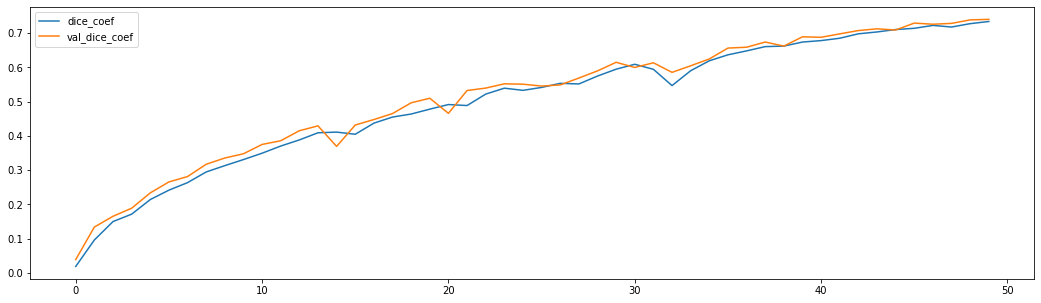

In [29]:
plt.figure(figsize=(18,5))
plt.plot(history['dice_coef'],label = "dice_coef")
plt.plot(history['val_dice_coef'], label="val_dice_coef")
plt.legend()
plt.show();

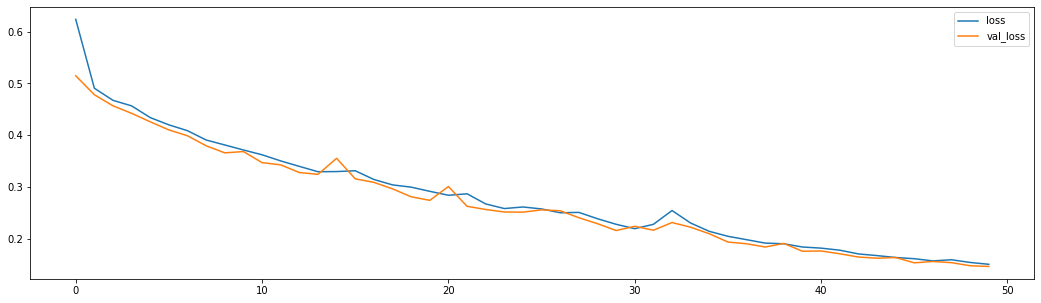

In [30]:
plt.figure(figsize=(18,5))
plt.plot(history['loss'],label = "loss")
plt.plot(history['val_loss'], label="val_loss")
plt.legend()
plt.show();



#Predicciones

##Generar data

In [31]:
path_test = "/content/drive/Shareddrives/Redes de Piluchina/TP 3/dataset/siim-acr-pneumothorax/"

* Dataset 2000

In [32]:
datagen_test_2 = DataGenerator_2(
    path_test,
    "png_image/img/",
    "png_masks/img/",
    transform = False,
    shuffle= False,
    batch_size = 64,
    train = False, 
)

In [33]:
datagen_test_2[0][0].shape

(64, 64, 64, 1)

##Caso 7

* 2000 imagenes, con Transform= False y epocs= 50

In [34]:
pred_test = model.predict(datagen_test_2)

4/4 [==============================] - 369s 123s/step


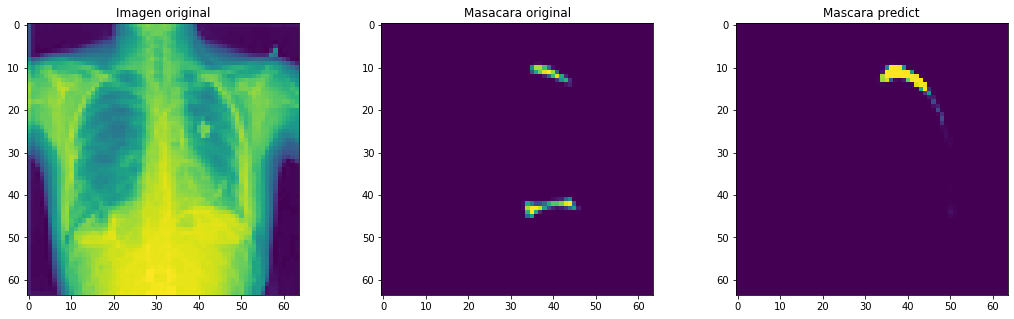

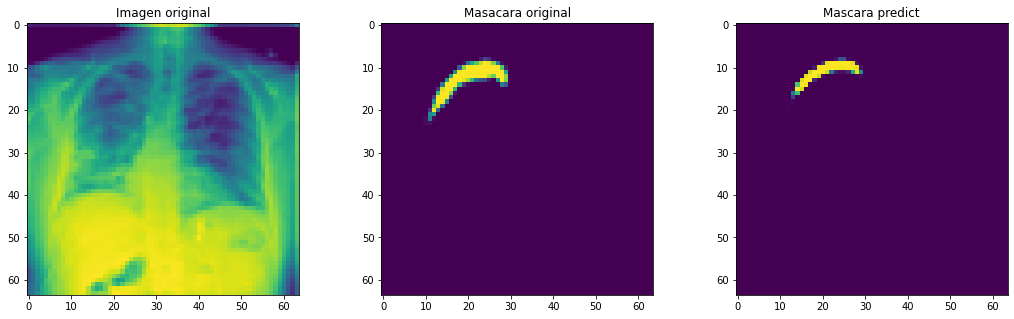

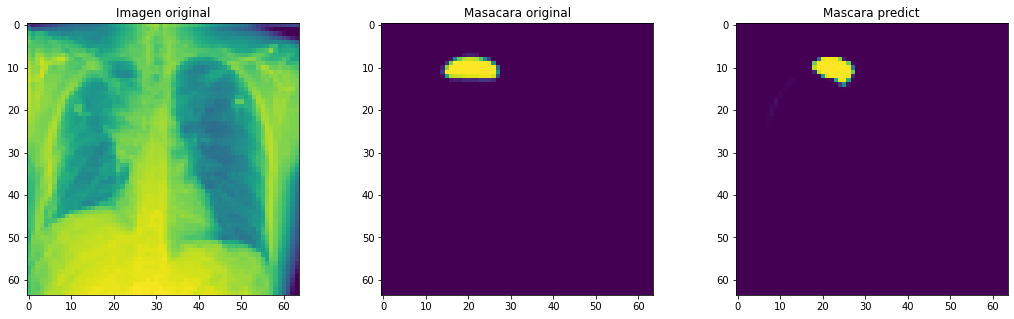

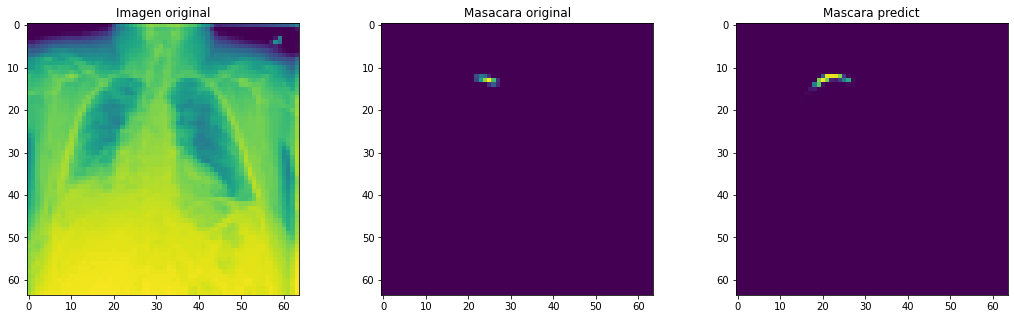

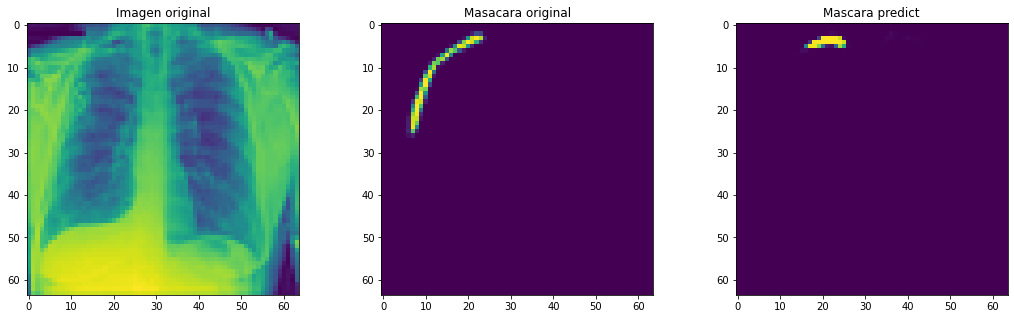

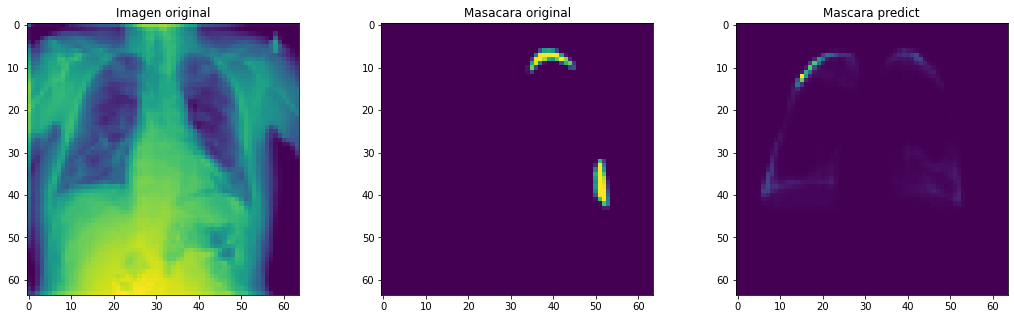

In [35]:
for idx in range(6):
  f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(18,5))
  ax1.imshow(datagen_test_2[0][0][idx].reshape(64,64))
  ax1.set_title("Imagen original")
  ax2.imshow(datagen_test_2[0][1][idx].reshape(64,64))
  ax2.set_title("Masacara original")
  ax3.imshow(pred_test[idx].reshape(64,64))
  ax3.set_title("Mascara predict")
  plt.show();